# Introduction

The sizedistribution module contains various classes associated  with sizedistributions:
- SizeDist  - a one dimentional size distribution
- SizeDist_TS - size distribution time series
- SizeDist_LS - size distribution layer series
- OpticalProperties - optical properties derived from one of the sizedistribution classes above

All sizedistribution classes are relatives of each other with SizeDist beeing the parent. In other words SizeDist_TS and SizeDist_LS can do exactly the same things like SizeDist and a bit more.

In addition to the classes sizedistribution also contains a few usefull functions:
- simulate_sizedistribution, simulate_sizedistribution_timeseries, and simulate_sizedistribution_layerseries - the name speaks for themself.

# Imports

In [1]:
from atmPy.aerosols.size_distribution import sizedistribution as sd
from atmPy.general import timeseries
from atmPy.aerosols.instruments.piccolo import piccolo
from atmPy.tools import plt_tools
from atmPy.data_archives import arm
import pandas as pd
import numpy as np
%matplotlib inline
try:
    plt.style.use('hagen_default')
except:
    pass

# SizeDist

Due to the similarity to SizeDist_TS and SizeDist_LS I will skip this class. It will show up every now and then below.

# SizeDist_TS

## simulate size distribution 

In [2]:
dist = sd.simulate_sizedistribution_timeseries()

## Load a size distribution

Usually a SizeDistribution is generated by reading experimental data using a module designed for the particular instrument (pick one from in atmPy.instruments). The following is a size distribution recorded using a POPS instrument.

In [3]:
dist_TS = sd.read_csv('./data/POPS_dist_TS.csv')
dist_TS._data_period = 1

dist_arm = arm.read_netCDF('../atmPy/unit_testing/test_data/sgptdmaapssizeC1.c1.20120601.004227.cdf', data_quality='bad').size_distribution

/Users/htelg/prog/atm-py/atmPy/aerosols/size_distribution/sizedistribution.py:1187: UserWarning: This function is deprecated use close_gaps instead ... unless you like thisone better
  _warnings.warn('This function is deprecated use close_gaps instead ... unless you like thisone better')


(<matplotlib.figure.Figure at 0x10ce3b668>,
 <matplotlib.colorbar.Colorbar at 0x10d519da0>)

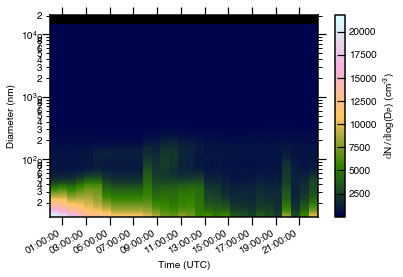

In [13]:
dist_arm.plot()

In [4]:
dist_TS.data.index.values

array(['2015-04-21T07:52:58.542969000', '2015-04-21T07:52:59.539062000',
       '2015-04-21T07:53:00.541016000', ...,
       '2015-04-21T10:22:08.546875000', '2015-04-21T10:22:09.542969000',
       '2015-04-21T10:22:10.546875000'], dtype='datetime64[ns]')

(<matplotlib.figure.Figure at 0x1134a76d8>,
 <matplotlib.colorbar.Colorbar at 0x118c7cb38>)

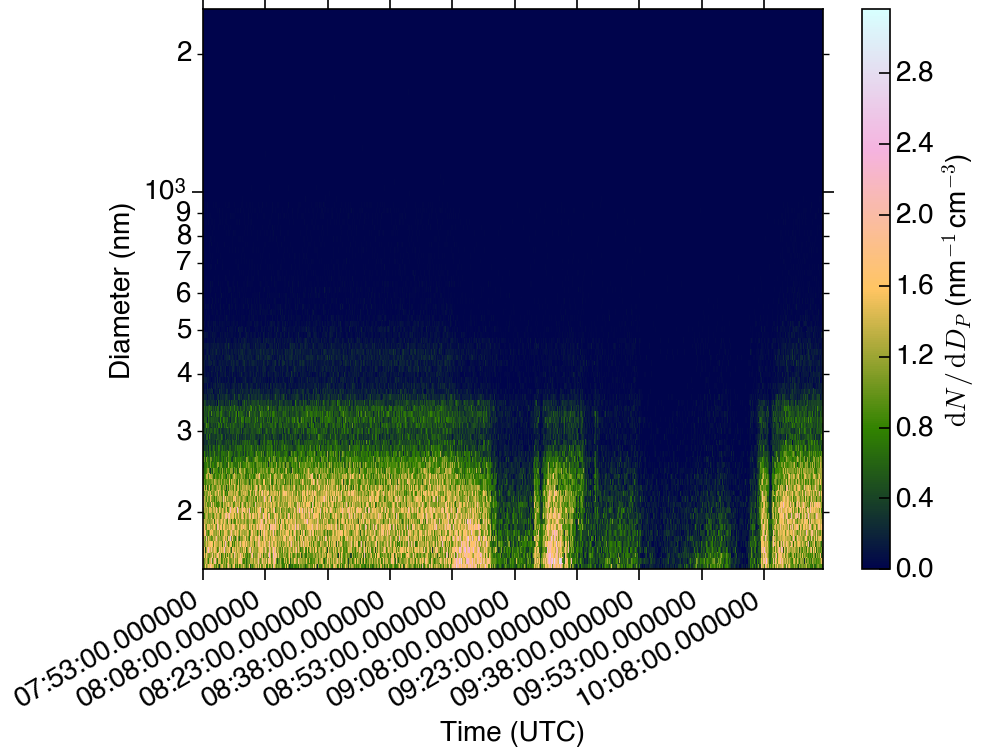

In [5]:
dist_TS.plot()

## Perform data operation

You probably want to normalize the particle rates to particle concentrations by dividing by the flow rate. It is important not to apply operations solely to the data container. Instead perform the opperation on the entire sizedistribution instance. 

e.g. POPS has a flow rate of 3cc/s ->

In [ ]:
dist_TS /= 3 

## Moment conversion

Current moment:

In [4]:
dist_TS.distributionType

'dNdDp'

<IPython.core.display.Javascript object>


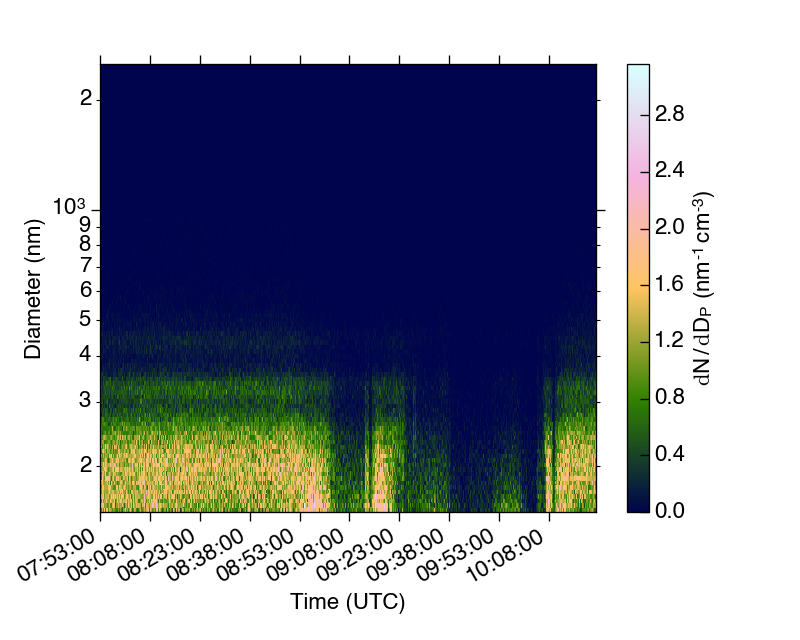

(<matplotlib.figure.Figure at 0x10656bd30>,
 <matplotlib.colorbar.Colorbar at 0x1053236d8>)

In [7]:
dist_TS.plot()

In [10]:
dist_TS = dist_TS.convert2dVdlogDp()

<IPython.core.display.Javascript object>


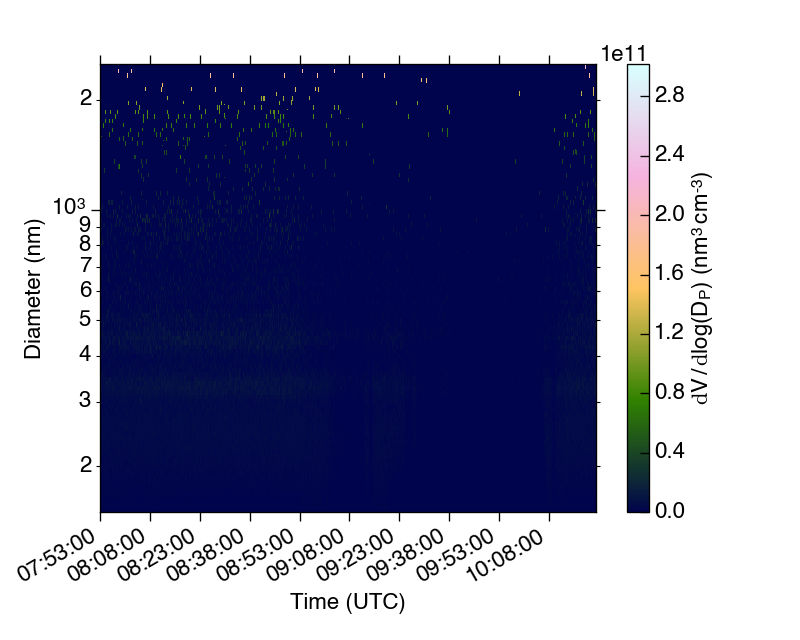

(<matplotlib.figure.Figure at 0x10dafad68>,
 <matplotlib.colorbar.Colorbar at 0x10fa66748>)

In [11]:
dist_TS.plot()

Now its different:

In [52]:
dist_TS.distributionType

'dNdlogDp'

There are plenty more, just play with the auto-completion.

## Fitting normal distribution to sizedistribution

This can take some time.

In [53]:
out = dist_TS.fit_normal()

See effect below in the plots

## Plottin stuff

All plotting functions will return matplotlib figures and axes, so further manipulation is possible.
The also have a lot of optional arguments that are worth exploring.

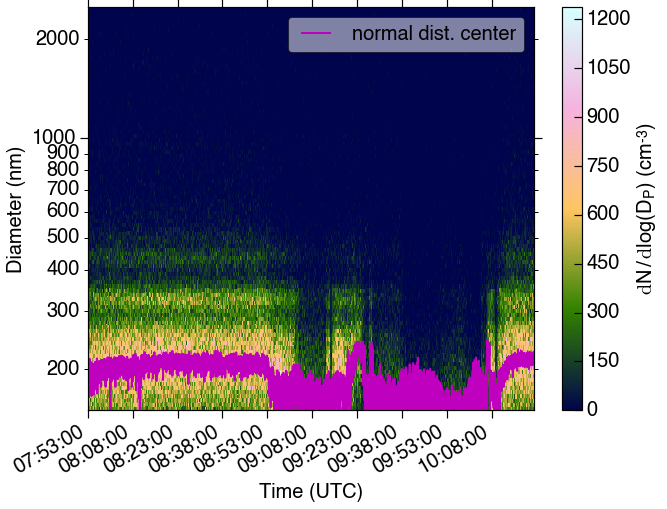

In [54]:
out = dist_TS.plot()

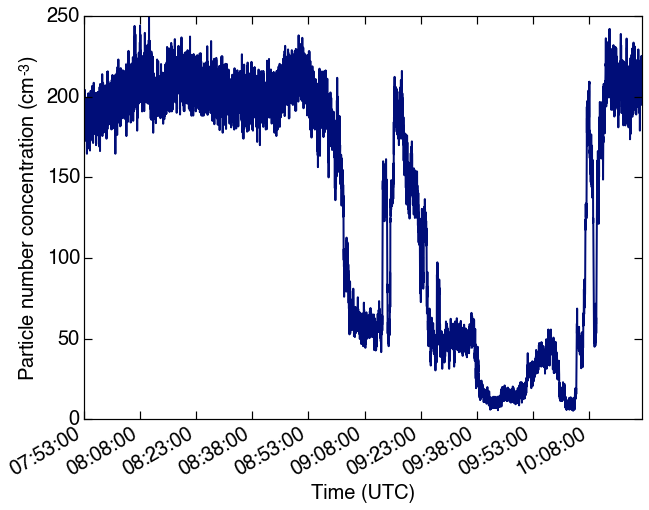

In [55]:
out = dist_TS.plot_particle_concentration()

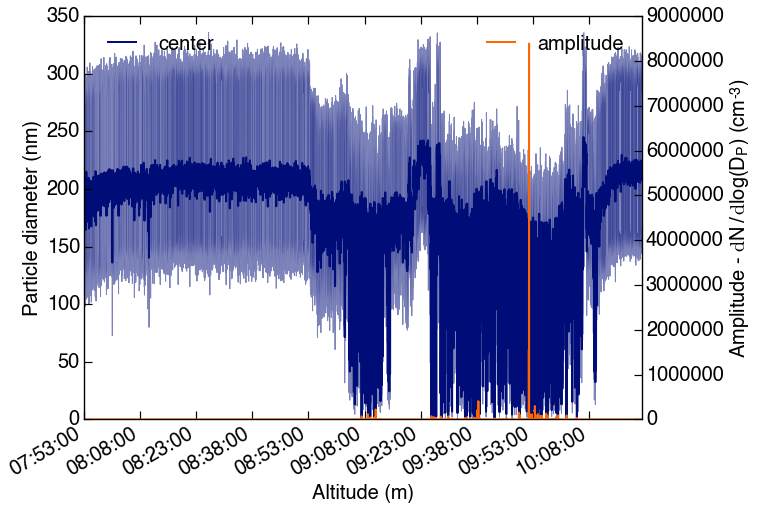

In [56]:
out = dist_TS.plot_fitres()

## Change time or diameter inteveral

In [57]:
dist_TS.get_timespan()

(Timestamp('2015-04-21 07:52:58.542969'),
 Timestamp('2015-04-21 10:22:10.546875'))

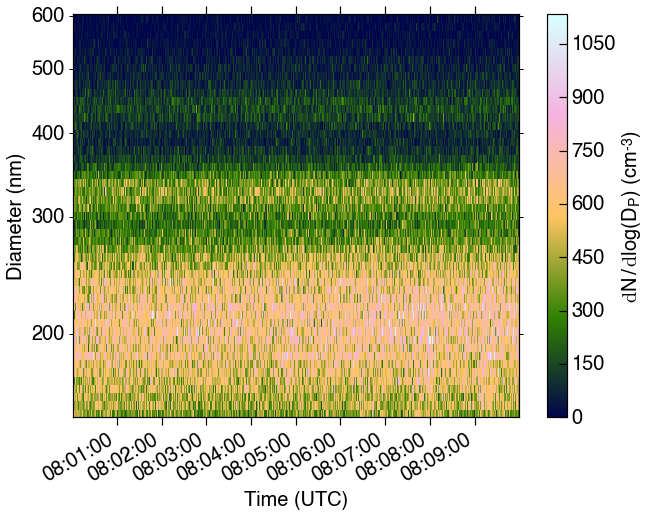

In [58]:
dt = dist_TS.zoom_time(start = '2015-04-21 08:00:00.00', end = '2015-04-21 08:10:00.00')
dt = dt.zoom_diameter(start = 150, end = 600)
out = dt.plot(fit_pos=False) 

## Averaging over time

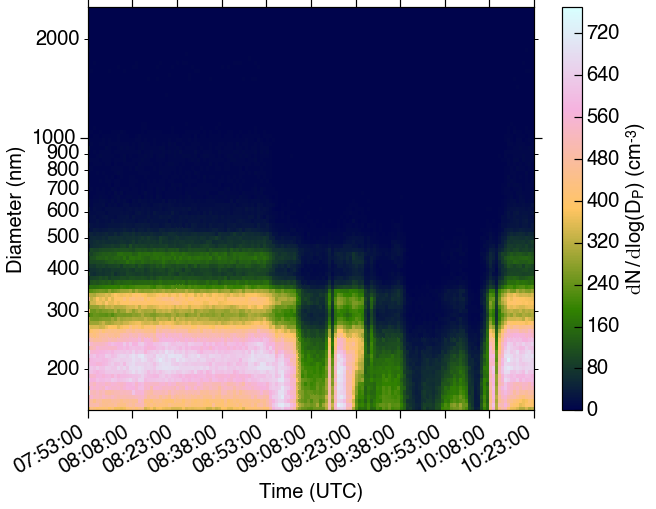

In [59]:
dt = dist_TS.average_overTime(window = '60S')
out = dt.plot(fit_pos=False)

The following will return a SizeDist instance since it is no longer a time series

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


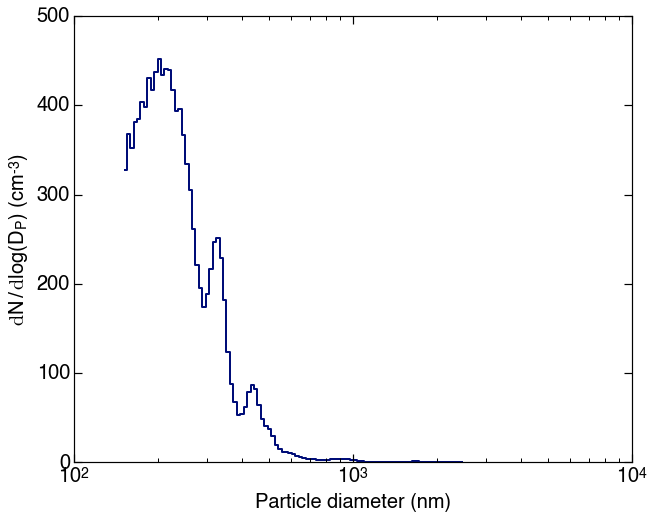

In [60]:
avg = dist_TS.average_overAllTime()
out = avg.plot()

## Mode selection

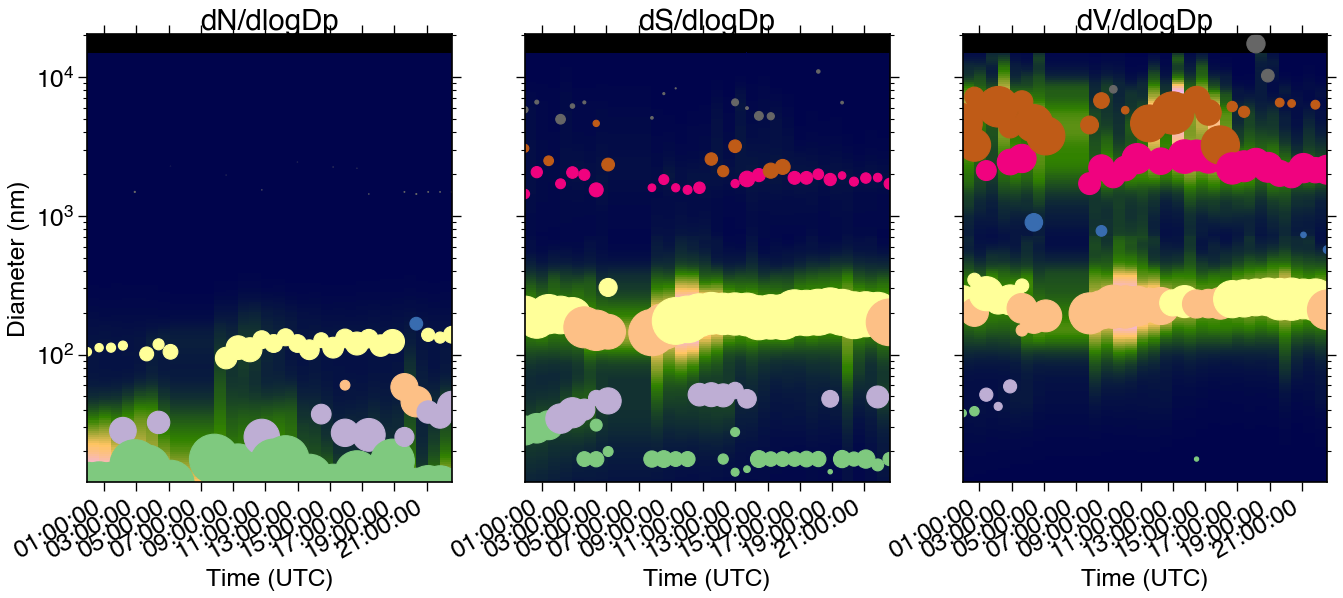

In [21]:
dist_arm_N = dist_arm.convert2dNdlogDp()
dist_arm_S = dist_arm.convert2dSdlogDp()
dist_arm_V = dist_arm.convert2dVdlogDp()

f,a = plt.subplots(1,3, sharey=True)
f.set_figwidth(20)
aN = a[0]
aS = a[1]
aV = a[2]

dist_arm_N.plot(ax = aN, colorbar= False)
dist_arm_N.mode_analysis.fit_results.plot(ax = aN)
aN.set_title('dN/dlogDp')

dist_arm_S.plot(ax = aS, colorbar= False)
dist_arm_S.mode_analysis.fit_results.plot(ax = aS)
aS.set_title('dS/dlogDp')
aS.set_ylabel('')

dist_arm_V.plot(ax = aV, colorbar= False)
dist_arm_V.mode_analysis.fit_results.plot(ax = aV)
aV.set_title('dV/dlogDp')
aV.set_ylabel('')

# SizeDist_LS

## generating a SizeDist_LS instance

Before we can generate a layerseries we need a time series that contains information about Altitude. Furthermore we want to truncate the data to the timeperiode during which a vertical profile was taken.

In [4]:
from atmPy.aerosols.instruments.Manta_payload import manta_payload

In [4]:
hk = piccolo.read_csv('./data/piccolo.log')
hk_II = manta_payload.read_csv('./data/Manta_raw.dat')
hk = hk.merge(hk_II)
spiral_up_start = '2015-04-21 08:20:54'
spiral_up_end = '2015-04-21 09:58:21'
dist_TS = dist_TS.zoom_time(spiral_up_start,spiral_up_end)
hk = hk.zoom_time(spiral_up_start,spiral_up_end)
hk._data_period = 1
dist_TS.housekeeping = hk

NameError: name 'manta_payload' is not defined

The following will generate the SizeDist_LS instance with a layer thickness of 30 meters. (force is necessary since the Altitude time series is not monotonic)

In [ ]:
# dist_LS = dist_TS.convert2layerseries(hk, layer_thickness= 30, force = True)
dist_LS = dist_TS.convert2verticalprofile(laythick= 30)

## Plotting stuff (LS)

/Users/htelg/prog/atm-py/atmPy/aerosols/size_distribution/sizedistribution.py:623: UserWarning: Size distribution is not in 'dNdlogDp'. I temporarily converted the distribution to conduct the fitting. If that is not what you want, change the code!
  "Size distribution is not in 'dNdlogDp'. I temporarily converted the distribution to conduct the fitting. If that is not what you want, change the code!")


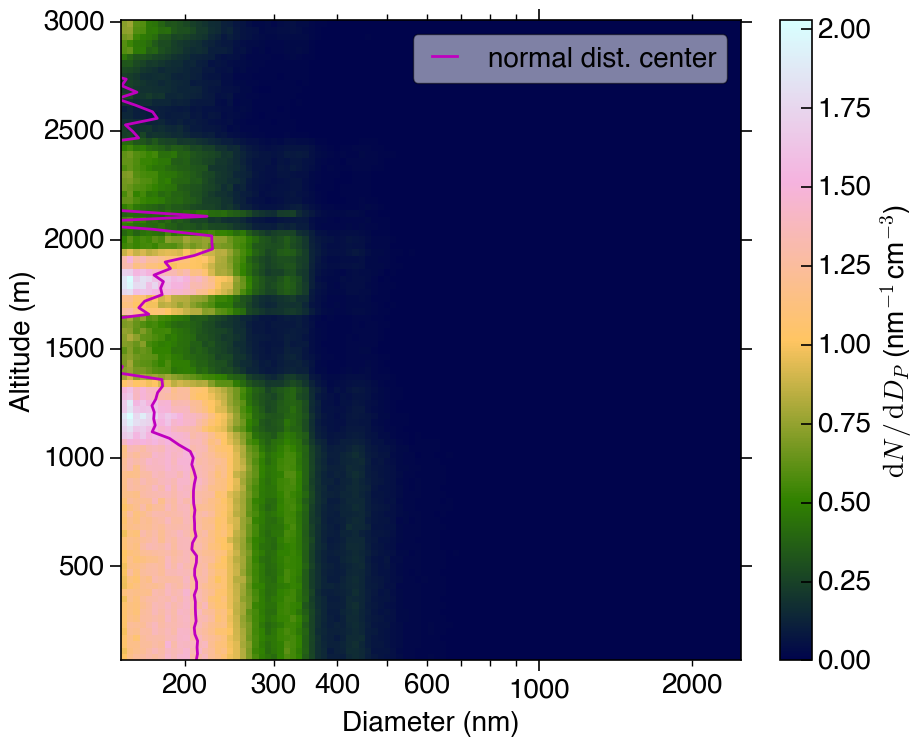

In [27]:
out = dist_LS.fit_normal()
out = dist_LS.plot()

## Particle number/surface/volume/mass concentrations

In [1]:
from atmPy.aerosols.size_distribution import sizedistribution

In [50]:
from atmPy.general import vertical_profile

In [8]:
dt = dist_LS.reduce2temp_press_ambient()
dts = dist_LS.reduce2temp_press_standard()

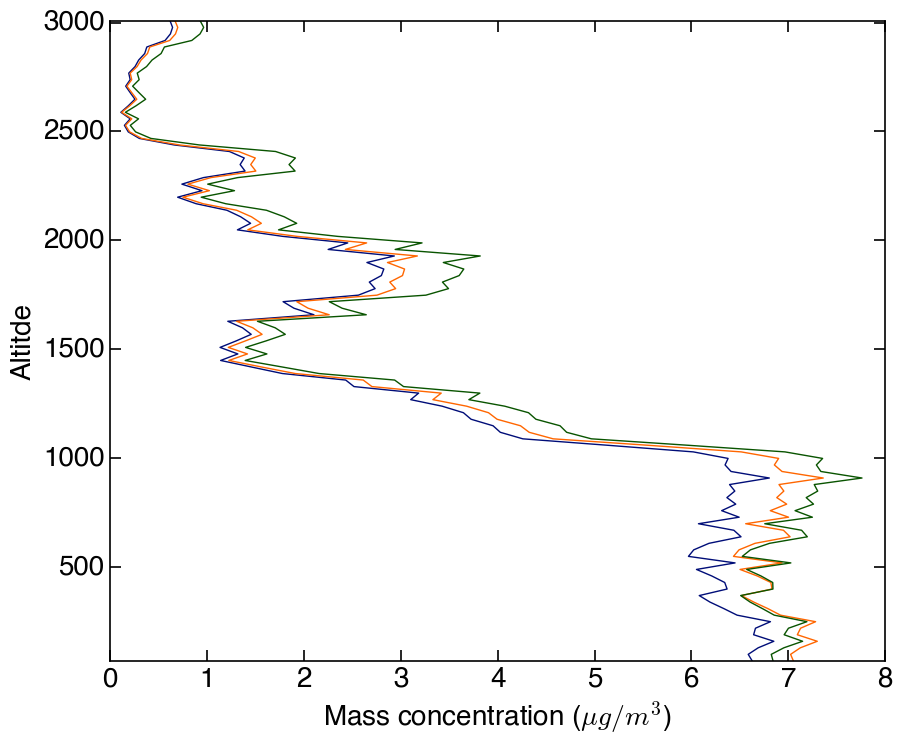

In [11]:
a = dist_LS.particle_mass_concentration.plot()
dt.particle_mass_concentration.plot(ax = a)
dts.particle_mass_concentration.plot(ax=a)


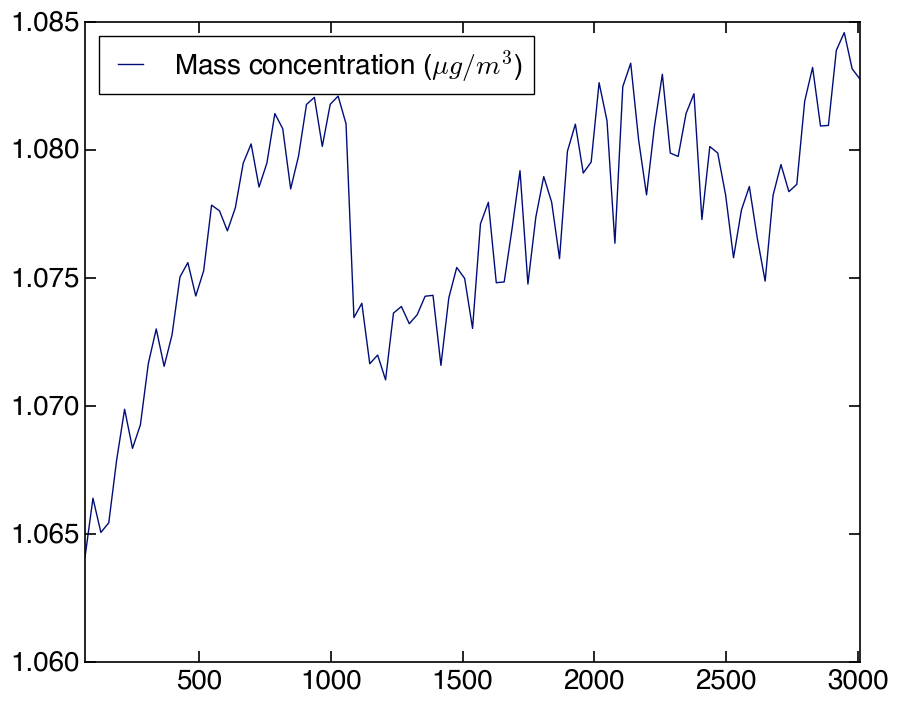

In [11]:
(dt.particle_mass_concentration.data / dist_LS.particle_mass_concentration.data).plot()

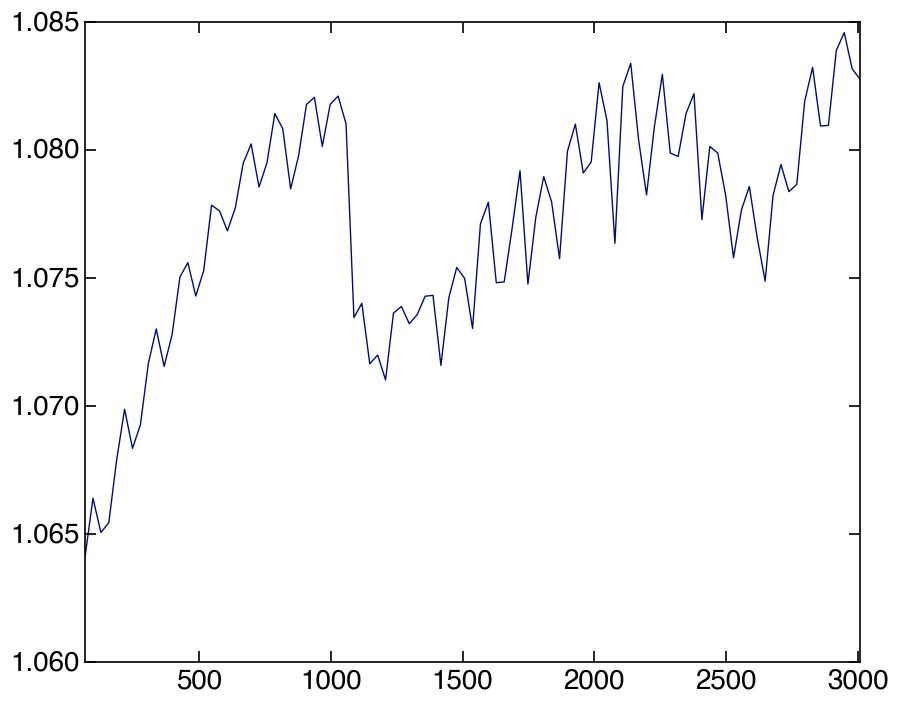

In [18]:
((dist_LS.housekeeping.data.Temperature_instrument + 273.15) / (dist_LS.housekeeping.data.Temperature +273.15)).plot()


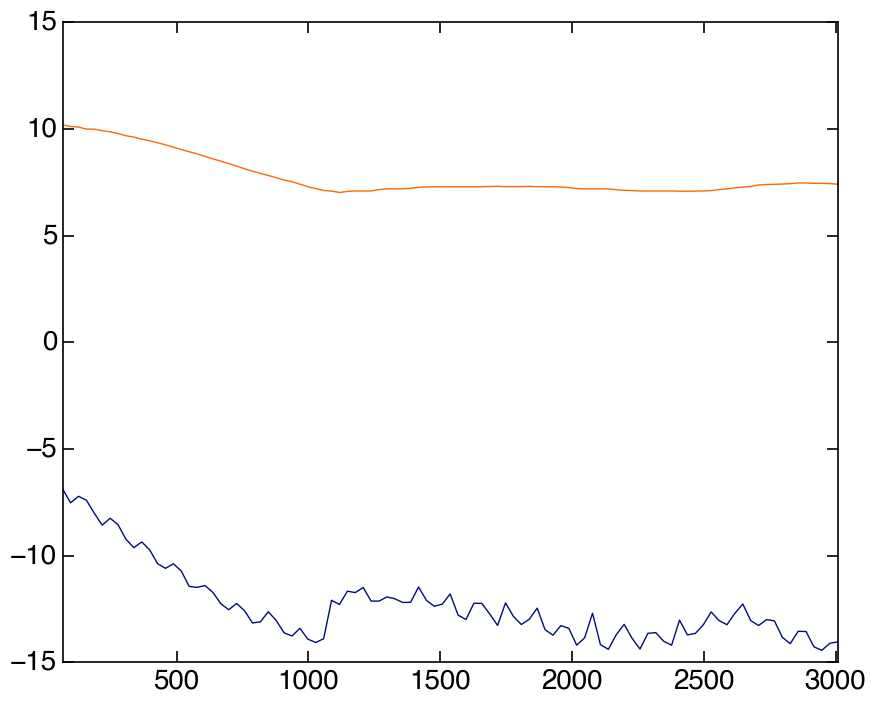

In [14]:
a = dist_LS.housekeeping.data.Temperature.plot()
dist_LS.housekeeping.data.Temperature_instrument.plot(ax = a)

In [20]:
dist = dist_LS.copy()

In [47]:
data = dist.data.iloc[0:5, :]
press_is = dist.housekeeping.data.iloc[0:5]['Pressure_Pa']
tmp_is = dist.housekeeping.data.iloc[0:5]['Temperature_instrument'] + 273.15

press_shall = dist.housekeeping.data.iloc[0:5]['Pressure_Pa']
tmp_shall = dist.housekeeping.data.iloc[0:5]['Temperature'] + 273.15

In [21]:
data = dist.data
press_is = dist.housekeeping.data['Pressure_Pa']
tmp_is = dist.housekeeping.data['Temperature_instrument'] + 273.15

press_shall = 1000
tmp_shall = 273.15

newdata = data.mul(tmp_is, axis = 0).truediv(press_is, axis=0).truediv(tmp_shall, axis = 0).mul(press_shall, axis = 0)

In [22]:
dist.data = newdata

(<matplotlib.figure.Figure at 0x114244630>,
 <matplotlib.colorbar.Colorbar at 0x1144c02b0>)

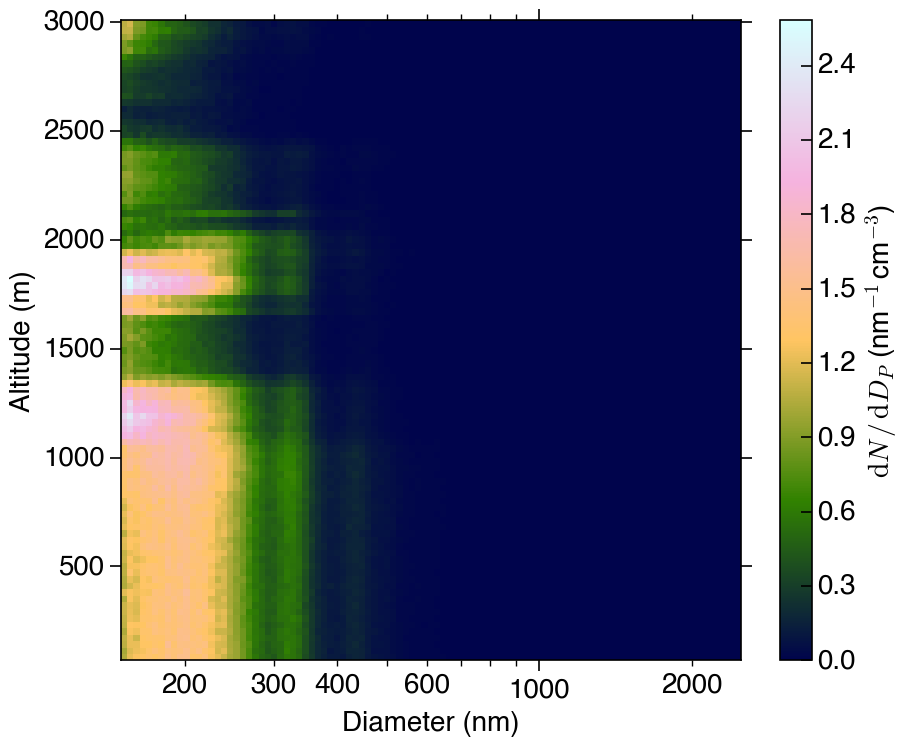

In [23]:
dist.plot()

In [16]:
dt.properties.particle_density = 1

In [19]:
dist_LS.properties.particle_density = 20

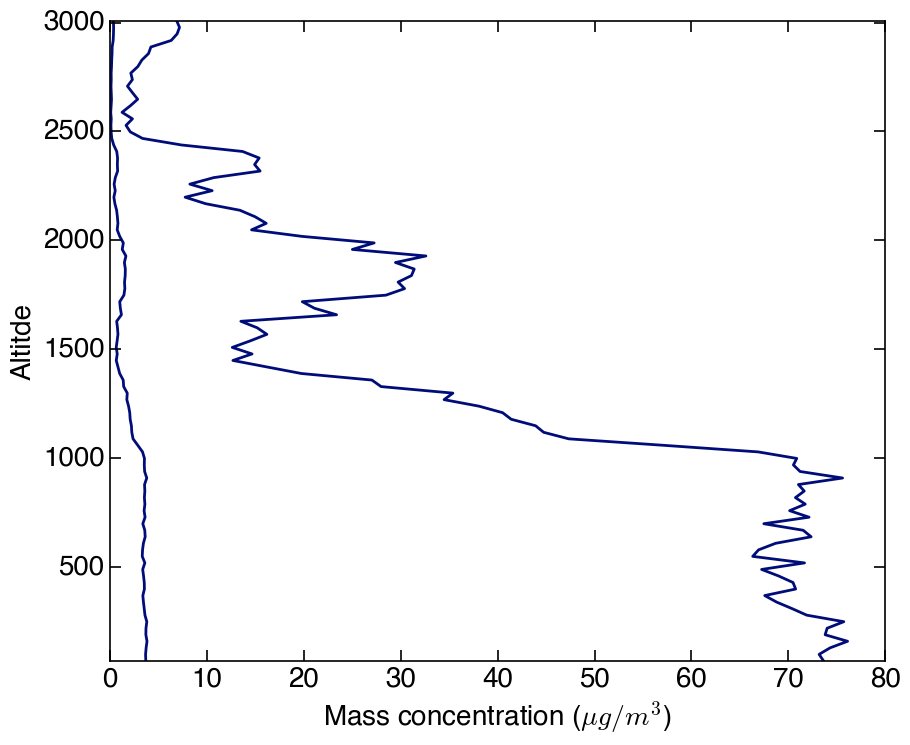

In [20]:
a = dist_LS.particle_mass_concentration.plot()
dt.particle_mass_concentration.plot(ax = a)

In [19]:
bla = dist_LS.optical_properties_settings.refractive_index._dict['value']

In [21]:
bla.__bool__()

True

In [12]:
from atmPy import atmosphere

In [25]:
reload(atmosphere)
reload(atmosphere.atmosphere)

<module 'atmPy.atmosphere.atmosphere' from '/Users/htelg/prog/atm-py/atmPy/atmosphere/atmosphere.py'>

In [21]:
for i in dist_LS.housekeeping.data.columns:
    print(i)



ABSFLOW
ABSFP
ABSLED
ABSRA
AFR
AFRcomp
AGL
AGLGood
AP_Mode
AX_Bias
AY_Bias
AZ_Bias
AccelGood
AckRatio
AeroTerm
Alt
Altitude
AttGood
BATTV
BaroGood
Boundary
BoxTemp
Brakes
CHEMFLOW
CHMFL
CHT_A
CHT_B
CPUFail
CommTimeout
Deadman
Direction
Drop
Dynamic
ECU_ERR_0
ECU_ERR_1
EGT_A
EGT_B
EngKill
EngineTime
ExtADC0
ExtADC1
ExtADC2
ExtADC3
FirstStageFail
FiveAFail
FiveDFail
FlightTerm
FlightTimer
FuelPress
GPSFail
GPSITOW
GPSTimeout
GPSWeek
GSDirection
GSGroundSpeed
GSHeight
GSLat
GSLon
GSPilotPrcnt
GSPilotRate
GSVDown
GSVEast
GSVNorth
GS_RSSI
GroundSpeed
GyroGood
IAT
InjectAngle
InjectTime
InputC
InputV
Lat
LeftRPM
Lights
Lon
LoopStatus6
LoopStatus7
LoopTarget0
LoopTarget1
LoopTarget2
LoopTarget3
LoopTarget4
LoopTarget5
MAP
MA_Mode
MBAlt
MBBelow
MBCross
MBDown
MBETA
MBEast
MBHead
MBLat
MBLon
MBNorth
MBSolnType
MBTime
MagBiasGood
MagGood
MagHdg
MagX
MagY
MagZ
OAT
OPCB4
OPCB5
OPCB6
OPCB7
OPCFL
OPCFLOW
Orbit
P
P_Bias
Parachute
PilotPrcnt
PilotRate
Pitch
PosGood
Pressure_Pa
Q
Q_Bias
R
RSSI
R_Bias

In [22]:
dist_LS.housekeeping.data.Pressure_Pa

68.0      1004.718054
98.0      1000.934414
128.0      997.448625
158.0      993.516933
188.0      989.653760
218.0      985.943403
248.0      981.928054
278.0      977.876513
308.0      974.214812
338.0      970.260960
368.0      966.881854
398.0      963.037267
428.0      959.310355
458.0      955.710030
488.0      951.954669
518.0      948.455896
548.0      944.791626
578.0      940.906873
608.0      937.135610
638.0      933.436374
668.0      930.074462
698.0      926.306921
728.0      922.805120
758.0      919.445278
788.0      915.591942
818.0      911.777140
848.0      908.157903
878.0      904.617622
908.0      901.191565
938.0      897.721062
             ...     
2138.0     766.752648
2168.0     763.646073
2198.0     760.654395
2228.0     757.626947
2258.0     754.602653
2288.0     751.362183
2318.0     748.566789
2348.0     745.571909
2378.0     742.815047
2408.0     739.618663
2438.0     736.661990
2468.0     733.891398
2498.0     731.092780
2528.0     728.325119
2558.0    

In [18]:
dist_LS.particle_volume_concentration.data

volume concentration $\mu m^3 / cm^{3}$
68.0                                   3.681984
98.0                                   3.659348
128.0                                  3.716356
158.0                                  3.806208
188.0                                  3.690323
218.0                                  3.700879
248.0                                  3.786778
278.0                                  3.595428
308.0                                  3.519840
338.0                                  3.440107
368.0                                  3.378525
398.0                                  3.538174
428.0                                  3.524586
458.0                                  3.450349
488.0                                  3.362613
518.0                                  3.583933
548.0                                  3.316558
578.0                                  3.346804
608.0                                  3.434439
638.0                                  3.618146
668.0                                  3.576974
698.0                                  3.373965
728.0                                  3.607334
758.0                                  3.507051
788.0                                  3.587794
818.0                                  3.537112
848.0                                  3.582445
878.0                                  3.552355
908.0                                  3.780381
938.0                                  3.560908
...                                         ...
2138.0                                 0.669815
2168.0                                 0.493437
2198.0                                 0.387231
2228.0                                 0.526640
2258.0                                 0.411520
2288.0                                 0.535123
2318.0                                 0.773995
2348.0                                 0.745659
2378.0                                 0.769211
2408.0                                 0.683971
2438.0                                 0.367498
2468.0                                 0.167283
2498.0                                 0.104162
2528.0                                 0.082084
2558.0                                 0.115201
2588.0                                 0.061557
2618.0                                 0.104313
2648.0                                 0.142245
2678.0                                 0.115331
2708.0                                 0.089424
2738.0                                 0.114910
2768.0                                 0.106805
2798.0                                 0.142890
2828.0                                 0.163728
2858.0                                 0.198273
2888.0                                 0.210405
2918.0                                 0.315223
2948.0                                 0.345617
2978.0                                 0.358154
3008.0                                 0.343782

[99 rows x 1 columns]

In [33]:
dist_LS.particle_volume_concentration.data[dist_LS.particle_volume_concentration.data.columns[0]] * dist_LS.housekeeping.data.Pressure_Pa.values

68.0      3699.355917
98.0      3662.767077
128.0     3706.874467
158.0     3781.531626
188.0     3652.142440
218.0     3648.856837
248.0     3718.343935
278.0     3515.884448
308.0     3429.080299
338.0     3337.801208
368.0     3266.634278
398.0     3407.393353
428.0     3381.172286
458.0     3297.532763
488.0     3201.055000
518.0     3399.202321
548.0     3133.456449
578.0     3149.030890
608.0     3218.535499
638.0     3377.309023
668.0     3326.851922
698.0     3125.327177
728.0     3328.866445
758.0     3224.541750
788.0     3284.955023
818.0     3225.057442
848.0     3253.425454
878.0     3213.522599
908.0     3406.847437
938.0     3196.702210
             ...     
2138.0     513.582266
2168.0     376.810913
2198.0     294.549241
2228.0     398.996823
2258.0     310.533740
2288.0     402.071181
2318.0     579.386680
2348.0     555.942445
2378.0     571.381348
2408.0     505.878054
2438.0     270.722059
2468.0     122.767706
2498.0      76.152374
2528.0      59.783738
2558.0    

In [45]:
data = dist_LS.particle_volume_concentration.data[dist_LS.particle_volume_concentration.data.columns[0]]
data

68.0      3.681984
98.0      3.659348
128.0     3.716356
158.0     3.806208
188.0     3.690323
218.0     3.700879
248.0     3.786778
278.0     3.595428
308.0     3.519840
338.0     3.440107
368.0     3.378525
398.0     3.538174
428.0     3.524586
458.0     3.450349
488.0     3.362613
518.0     3.583933
548.0     3.316558
578.0     3.346804
608.0     3.434439
638.0     3.618146
668.0     3.576974
698.0     3.373965
728.0     3.607334
758.0     3.507051
788.0     3.587794
818.0     3.537112
848.0     3.582445
878.0     3.552355
908.0     3.780381
938.0     3.560908
            ...   
2138.0    0.669815
2168.0    0.493437
2198.0    0.387231
2228.0    0.526640
2258.0    0.411520
2288.0    0.535123
2318.0    0.773995
2348.0    0.745659
2378.0    0.769211
2408.0    0.683971
2438.0    0.367498
2468.0    0.167283
2498.0    0.104162
2528.0    0.082084
2558.0    0.115201
2588.0    0.061557
2618.0    0.104313
2648.0    0.142245
2678.0    0.115331
2708.0    0.089424
2738.0    0.114910
2768.0    0.

In [51]:
dist_LS.physical_property_density = 2

In [48]:
bla = atmosphere.normalize2standard_pressure_and_temperature(dist_LS.particle_volume_concentration.data.iloc[:,0], 
                                                             dist_LS.housekeeping.data.Pressure_Pa, 
                                                             dist_LS.housekeeping.data.Temperature_instrument + 273.15)

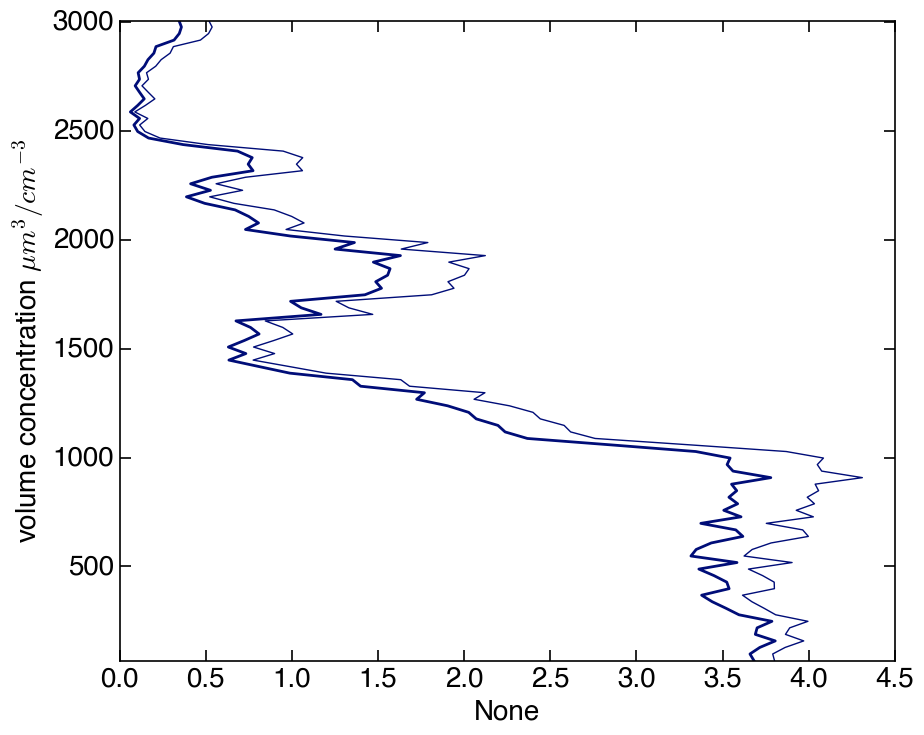

In [42]:
a = dist_LS.particle_volume_concentration.plot()
a.plot(bla.values, bla.index)

## hygroscopic growth

Hygroscopic growth can either be applied with one RH value or by using the 'Relative_humidity' column in the associated housekeeping file. We made sure that this column exist by merging the file from the manta aircraft earlier.
Since the index of refraction is adjusted during the growth it is nesecarry to define that value before proceeding.

In [8]:
dist_LS.hygroscopic_growth_settings.refractive_index = 1.455 # refractive index of the calibration material DOS
dist_LS_grown = dist_LS.apply_hygro_growth(0.5)
# out = dist_LS_grown.plot(fit_pos=False)

In [14]:
dist_LS_grown.optical_properties_settings

RecursionError: maximum recursion depth exceeded

(<matplotlib.figure.Figure at 0x1177ff518>,
 <matplotlib.colorbar.Colorbar at 0x116f443c8>)

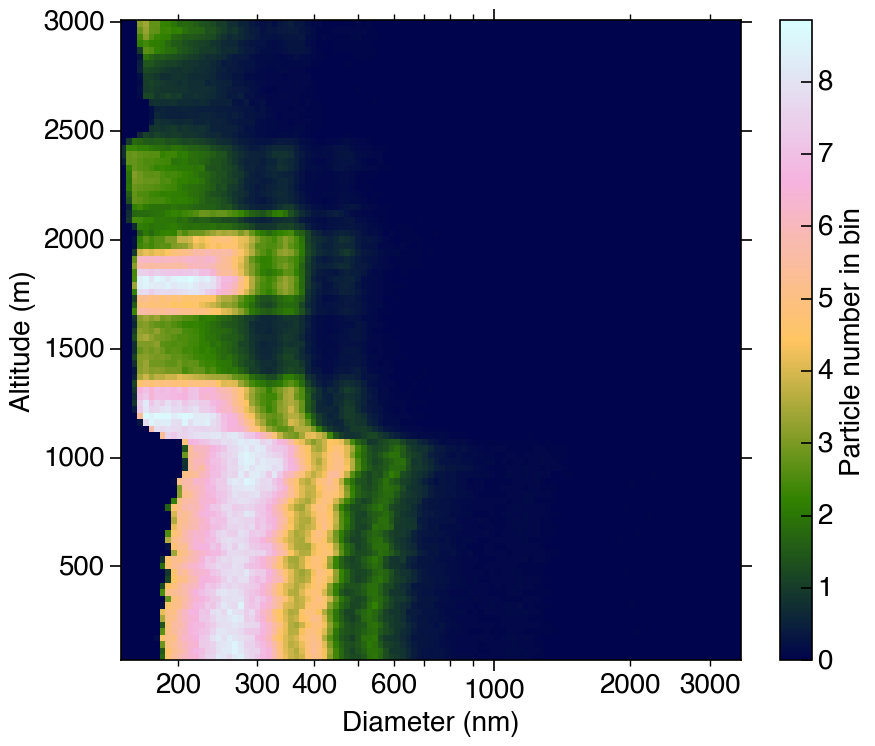

In [34]:
dist_LS_grown.plot()

# Optical properties

## generating OpticalProperties instance

To calculate optical properties it is again necessary to specify the refractive index, which we already did earlier. 

In [13]:
dist_LS.optical_properties_settings.refractive_index = 1.455
dist_LS.optical_properties_settings.wavelength = 550.4
opt_prop = dist_LS.optical_properties

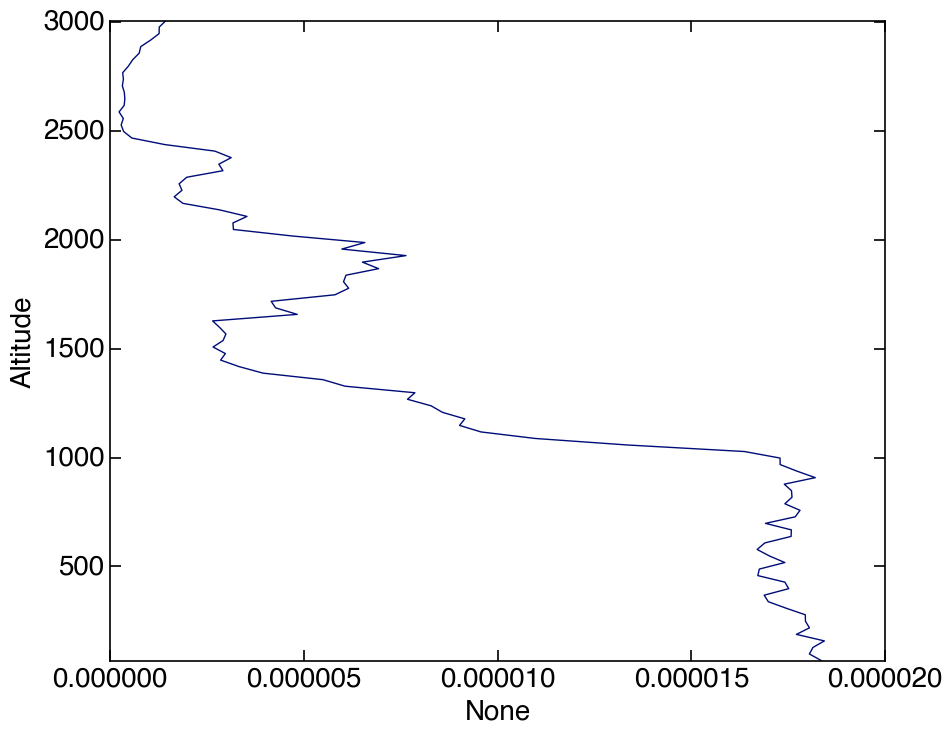

In [14]:
dist_LS.optical_properties.extinction_coeff.plot()

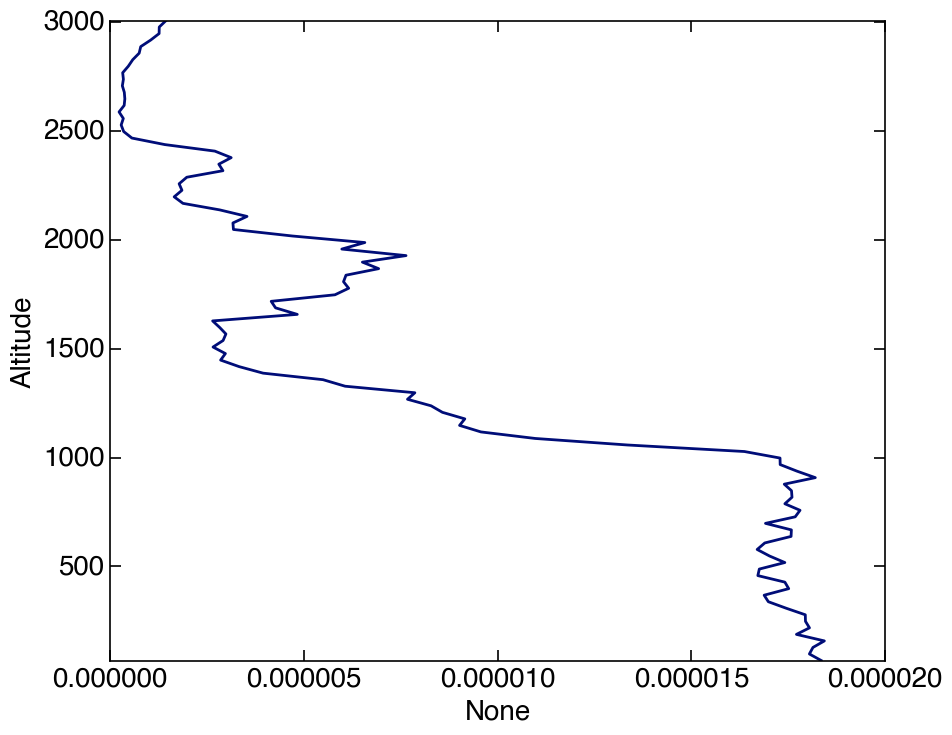

In [10]:
dist_LS.optical_properties.extinction_coeff.plot()

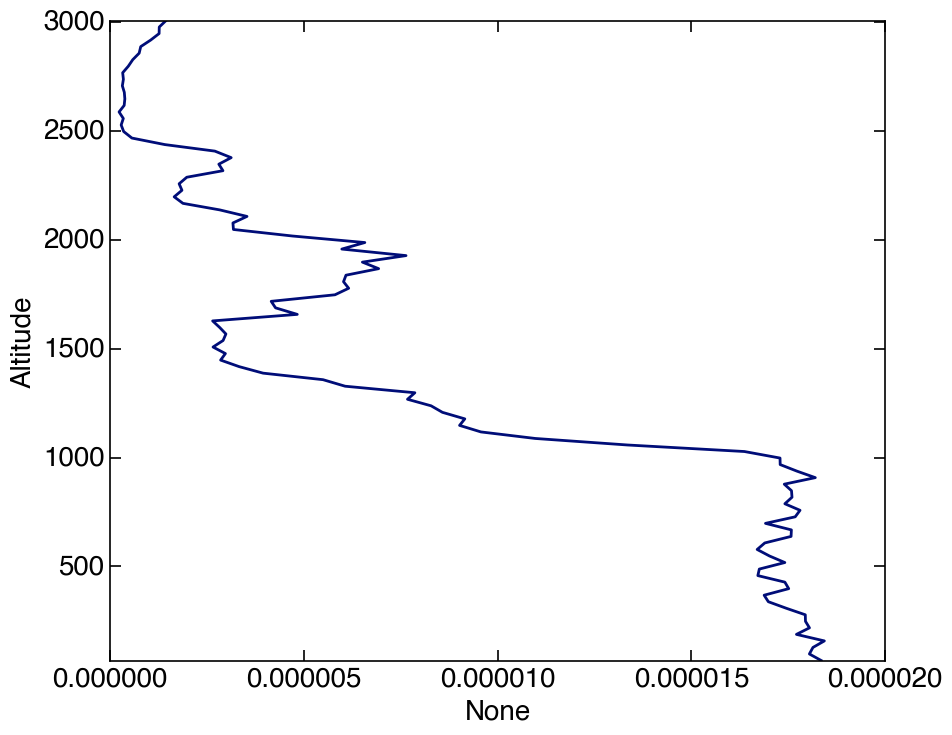

In [10]:
dist_LS.optical_properties.extinction_coeff.plot()

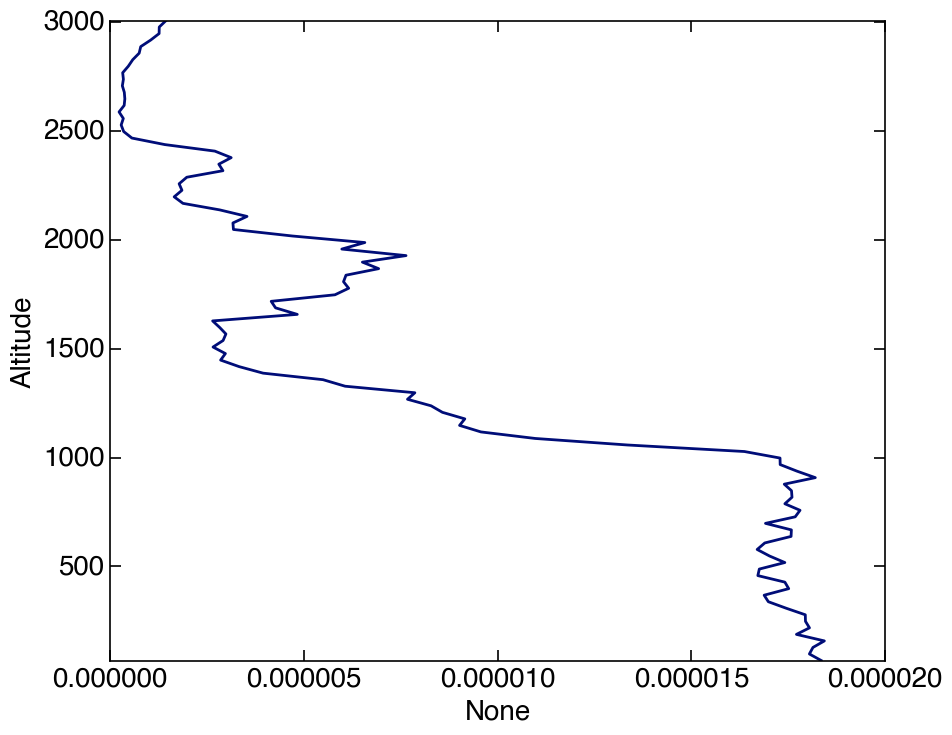

In [10]:
dist_LS.optical_properties.extinction_coeff.plot()

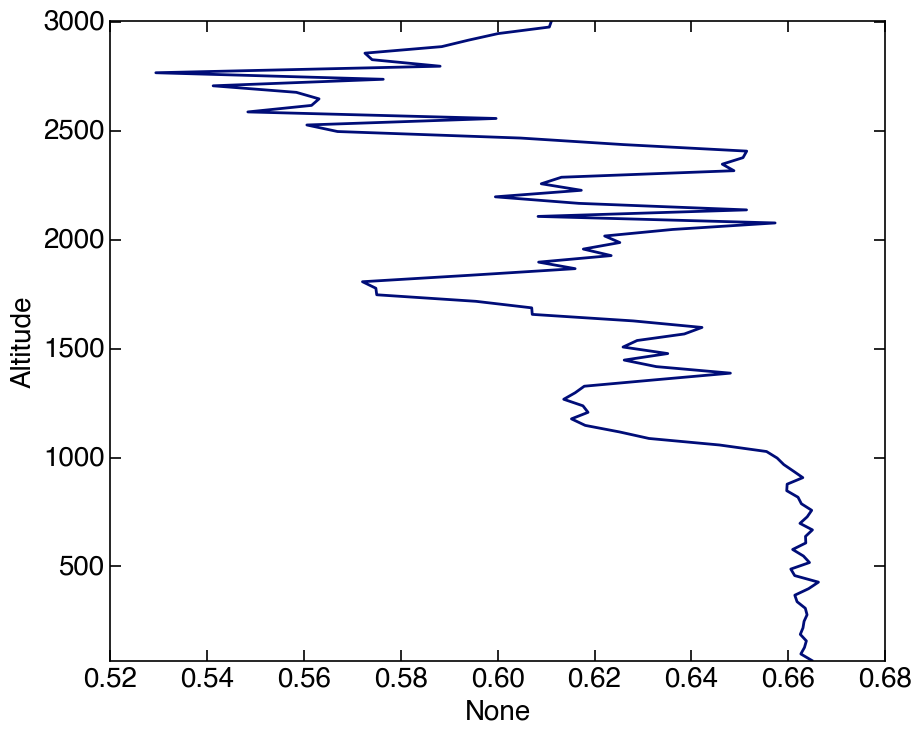

In [9]:
dist_LS.optical_properties.asymmetry_param_VP.plot()

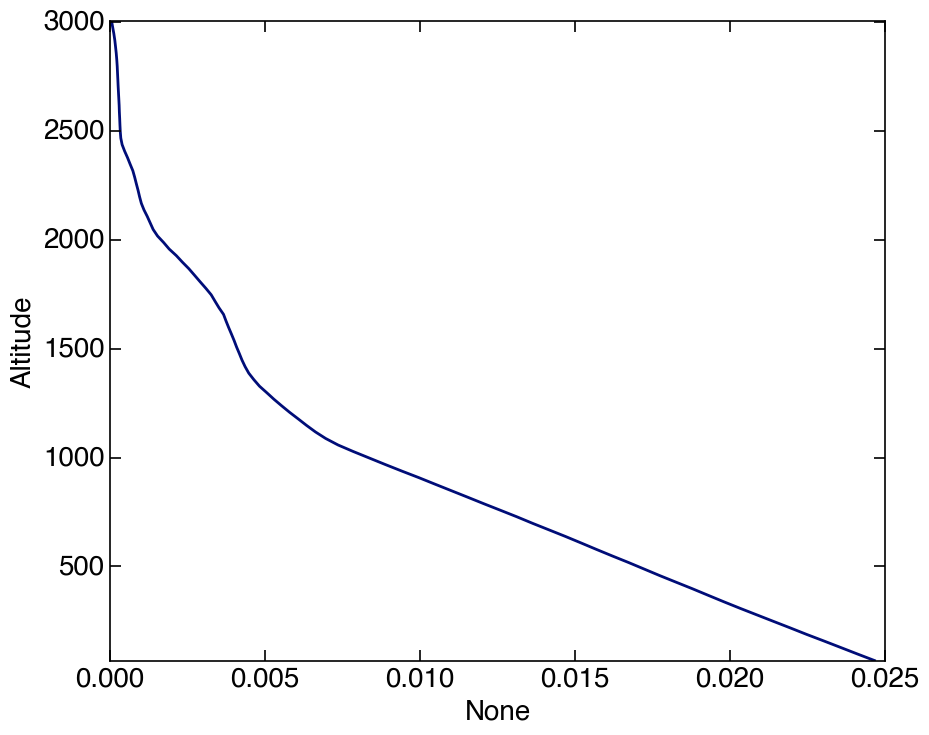

In [10]:
dist_LS.optical_properties.aerosol_optical_depth_cumulative_VP.plot()

TypeError: not possible for this distribution type